In [1]:
import numpy as np
import pydot
import pydrake
from pydrake.all import (
    DiagramBuilder,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    StartMeshcat,
    MeshcatVisualizer,
    SceneGraph,
    Simulator,
    AddMultibodyPlantSceneGraph,
    LeafSystem,
    LeafSystem_,
    ExternallyAppliedSpatialForce,
    ExternallyAppliedSpatialForce_,
    TemplateSystem,
    AbstractValue,
    SpatialForce,
    SpatialForce_,
    SpatialInertia,
    UnitInertia,
    CollisionFilterDeclaration,
    GeometrySet,
    Sphere
)
from pydrake.examples import (
    QuadrotorGeometry
)
from IPython.display import display, SVG, Image

from underactuated.scenarios import AddFloatingRpyJoint

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [12]:
@TemplateSystem.define("TensileForce_")
def TensileForce_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, length, hooke_K, quad_body_index, mass_body_index, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.length = length  # In meters, > 0
            self.hooke_K = hooke_K  # Hooke's law spring constant, > 0
            self.quad_body_index = quad_body_index  # Index of the affected body from the plant
            self.mass_body_index = mass_body_index  # Index of the affected body from the plant

            self.quad_state_input = self.DeclareVectorInputPort("quad_state_input", size=12)
            self.mass_state_input = self.DeclareVectorInputPort("mass_state_input", size=13)  # this is xyz quat state
            self.quad_force_output = self.DeclareAbstractOutputPort("quad_force_output",
                                                                    alloc=lambda: AbstractValue.Make(
                                                                        [ExternallyAppliedSpatialForce_[T]()]),
                                                                    calc=self.QuadOutputForce)
            self.mass_force_output = self.DeclareAbstractOutputPort("mass_force_output",
                                                                    alloc=lambda: AbstractValue.Make(
                                                                        [ExternallyAppliedSpatialForce_[T]()]),
                                                                    calc=self.MassOutputForce)

        def compute_spring_force(self, quad_pos, mass_pos):
            dist = np.linalg.norm(quad_pos - mass_pos)

            f_mag = pydrake.symbolic.max(0, self.hooke_K * (dist - self.length))
            if len(f_mag.GetVariables()) == 0:
                f_mag = f_mag.Evaluate()
            f_dir = (mass_pos - quad_pos) / dist
            return f_mag, f_dir

        def QuadOutputForce(self, context, output):
            quad_state = self.quad_state_input.Eval(context)
            quad_pos = quad_state[0:3]

            mass_state = self.mass_state_input.Eval(context)
            mass_pos = mass_state[4:7]

            f_mag, f_dir = self.compute_spring_force(quad_pos, mass_pos)
            f = f_mag * f_dir

            F_Bq_W = SpatialForce_[T](np.zeros((3, 1)), f.reshape(-1, 1))
            p_BoBq_B = np.zeros(3)  # Assume the force is applied at the body origin

            o = ExternallyAppliedSpatialForce_[T]()
            o.body_index = self.quad_body_index
            o.F_Bq_W = F_Bq_W
            o.p_BoBq_B = p_BoBq_B

            output.set_value([o])

            # TODO: Move this to its own system, or include a flag on whether to render or not?
            if type(quad_pos[0]) == np.float64:
                if f_mag == 0:
                    rgba = pydrake.geometry.Rgba(r=1, g=0, b=0)
                else:
                    rgba = pydrake.geometry.Rgba(r=0, g=1, b=0)
                meshcat.SetLine("cables/cable%d" % self.quad_body_index,
                                np.array([mass_pos, quad_pos]).T, rgba=rgba)

        def MassOutputForce(self, context, output):
            quad_state = self.quad_state_input.Eval(context)
            quad_pos = quad_state[0:3]

            mass_state = self.mass_state_input.Eval(context)
            mass_pos = mass_state[4:7] # TODO: we may be pulling the wrong state here.

            f_mag, f_dir = self.compute_spring_force(quad_pos, mass_pos)
            f = -f_mag * f_dir  # inverting for mass

            F_Bq_W = SpatialForce_[T](np.zeros((3, 1)), f.reshape(-1, 1))
            p_BoBq_B = np.zeros(3)  # Assume the force is applied at the body origin

            o = ExternallyAppliedSpatialForce_[T]()
            o.body_index = self.mass_body_index
            o.F_Bq_W = F_Bq_W
            o.p_BoBq_B = p_BoBq_B

            output.set_value([o])

        def _construct_copy(self, other, converter=None, ):
            Impl._construct(self, other.length, other.hooke_K,
                            other.quad_body_index, other.mass_body_index, converter=converter)

    return Impl


# Thanks David!
# https://stackoverflow.com/a/72121171/9796174
@TemplateSystem.define("SpatialForceConcatinator_")
def SpatialForceConcatinator_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, N_inputs, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.N_inputs = N_inputs
            self.Input_ports = [self.DeclareAbstractInputPort(f"Spatial_Force_{i}",
                                                              AbstractValue.Make([ExternallyAppliedSpatialForce_[T]()]))
                                for i in range(N_inputs)]

            self.Output_port = self.DeclareAbstractOutputPort("Spatial_Forces",
                                                              lambda: AbstractValue.Make(
                                                                  [ExternallyAppliedSpatialForce_[T]()
                                                                   for i in range(N_inputs)]),
                                                              self.Concatenate)

        def Concatenate(self, context, output):
            out = []
            for port in self.Input_ports:
                out += port.Eval(context)
            output.set_value(out)

        def _construct_copy(self, other, converter=None, ):
            Impl._construct(self, other.N_inputs, converter=converter)

    return Impl


@TemplateSystem.define("SpatialForceAdder_")
def SpatialForceAdder_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, N_inputs, mass_body_index, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.N_inputs = N_inputs
            self.mass_body_index = mass_body_index
            self.Input_ports = [self.DeclareAbstractInputPort(f"Spatial_Force_{i}",
                                                              AbstractValue.Make([ExternallyAppliedSpatialForce_[T]()]))
                                for i in range(N_inputs)]

            self.Output_port = self.DeclareAbstractOutputPort("force_output",
                                                               alloc=lambda: AbstractValue.Make(
                                                                   [ExternallyAppliedSpatialForce_[T]()]),
                                                               calc=self.AddForces)

        def AddForces(self, context, output):
            f_net = SpatialForce_[T](np.zeros((3, 1)), np.zeros((3, 1)))
            for port in self.Input_ports:
                f_net += port.Eval(context)[0].F_Bq_W

            o = ExternallyAppliedSpatialForce_[T]()
            o.body_index = self.mass_body_index
            o.F_Bq_W = f_net
            o.p_BoBq_B = np.zeros(3)
            output.set_value([o])

        def _construct_copy(self, other, converter=None, ):
            Impl._construct(self, other.N_inputs, other.mass_body_index, converter=converter)

    return Impl


# Default instantations
TensileForce = TensileForce_[None]
SpatialForceConcatinator = SpatialForceConcatinator_[None]
SpatialForceAdder = SpatialForceAdder_[None]

In [13]:
from pydrake.systems.primitives import Adder


def make_n_quadrotor_system(n, mass=1.0):
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant)
    parser.SetAutoRenaming(True)
    quadrotor_model_instances = []
    for i in range(n):
        (model_instance,) = parser.AddModelsFromUrl(
            "package://drake/examples/quadrotor/quadrotor.urdf"
        )
        quadrotor_model_instances.append(model_instance)
        # By default the multibody has a quaternion floating base.  To match
        # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
        # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
        # instead of ṙ, ṗ, ẏ.
        AddFloatingRpyJoint(
            plant,
            plant.GetFrameByName("base_link", model_instance),
            model_instance,
            use_ball_rpy=False,
        )

    # form spatial inertia of floating mass (SpatialInertia factory methods are not available from Python,
    # so we'll need to construct it ourselves)
    point_inertia = SpatialInertia(mass, np.zeros(3), UnitInertia.SolidSphere(1))
    print(point_inertia.IsPhysicallyValid())

    # create floating mass and register visual geometry with scenegraph so it renders
    floating_mass_model_instance = plant.AddModelInstance("floating_mass")
    floating_mass = plant.AddRigidBody("base_link", floating_mass_model_instance, point_inertia)
    plant.RegisterVisualGeometry(
        floating_mass,
        RigidTransform.Identity(),
        Sphere(0.1),
        "floating_mass_sphere",
        np.array([1.0, 0.0, 0.0, 1.0])
    )

    plant.Finalize()

    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Now we can add in propellers as an external force on the MultibodyPlant.
    prop_info = []
    tensile_forces = []

    mass_body_index =  plant.GetBodyByName("base_link", floating_mass_model_instance).index()
    for model_instance in quadrotor_model_instances:
        quad_body_index = plant.GetBodyByName("base_link", model_instance).index()
        # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
        prop_info += [
            PropellerInfo(quad_body_index, RigidTransform([L, 0, 0]), kF, kM),
            PropellerInfo(quad_body_index, RigidTransform([0, L, 0]), kF, -kM),
            PropellerInfo(quad_body_index, RigidTransform([-L, 0, 0]), kF, kM),
            PropellerInfo(quad_body_index, RigidTransform([0, -L, 0]), kF, -kM),
        ]
        tensile_force = builder.AddSystem(TensileForce(2, 10, quad_body_index, mass_body_index))
        builder.Connect(
            plant.get_state_output_port(model_instance),
            tensile_force.quad_state_input
        )
        builder.Connect(
            plant.get_state_output_port(floating_mass_model_instance),
            tensile_force.mass_state_input
        )
        tensile_forces.append(tensile_force)

    propellers = builder.AddNamedSystem("propeller", Propeller(prop_info))

    combiner = builder.AddNamedSystem("combiner", SpatialForceConcatinator(2))
    builder.Connect(
        propellers.get_output_port(),
        combiner.Input_ports[0]
    )
    builder.Connect(
        combiner.Output_port,
        plant.get_applied_spatial_force_input_port()
    )

    tensile_combiner = builder.AddNamedSystem("tensile_combiner", SpatialForceConcatinator(2 * n))
    # floating_mass_force_adder = builder.AddNamedSystem("floating_mass_force_adder", SpatialForceAdder(n, mass_body_index))
    for i, tensile_force in enumerate(tensile_forces):
        builder.Connect(
            tensile_force.quad_force_output,
            tensile_combiner.Input_ports[i]
        )

        builder.Connect(
            tensile_force.mass_force_output,
            tensile_combiner.Input_ports[n + i]
        )

    builder.Connect(
        tensile_combiner.Output_port,
        combiner.Input_ports[1]
    )

    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    return builder.Build(), plant

In [14]:
diagram, plant = make_n_quadrotor_system(3)

True


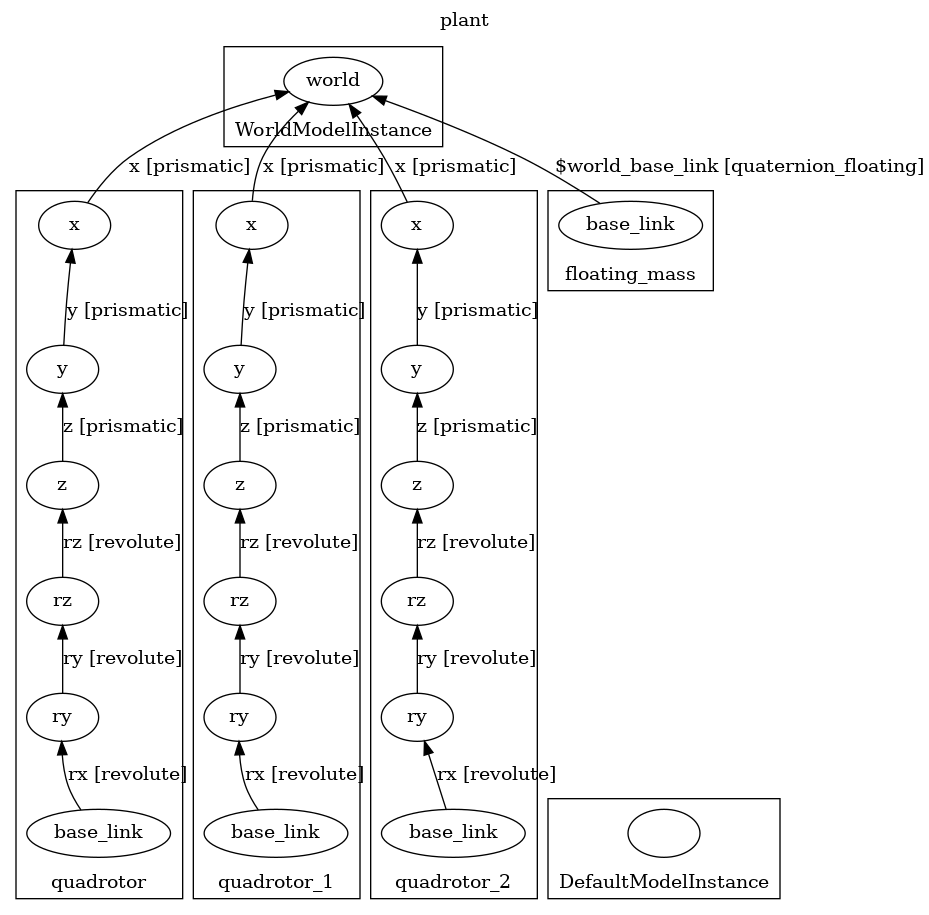

In [15]:
display(
    Image(
        pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_png()
    )
)

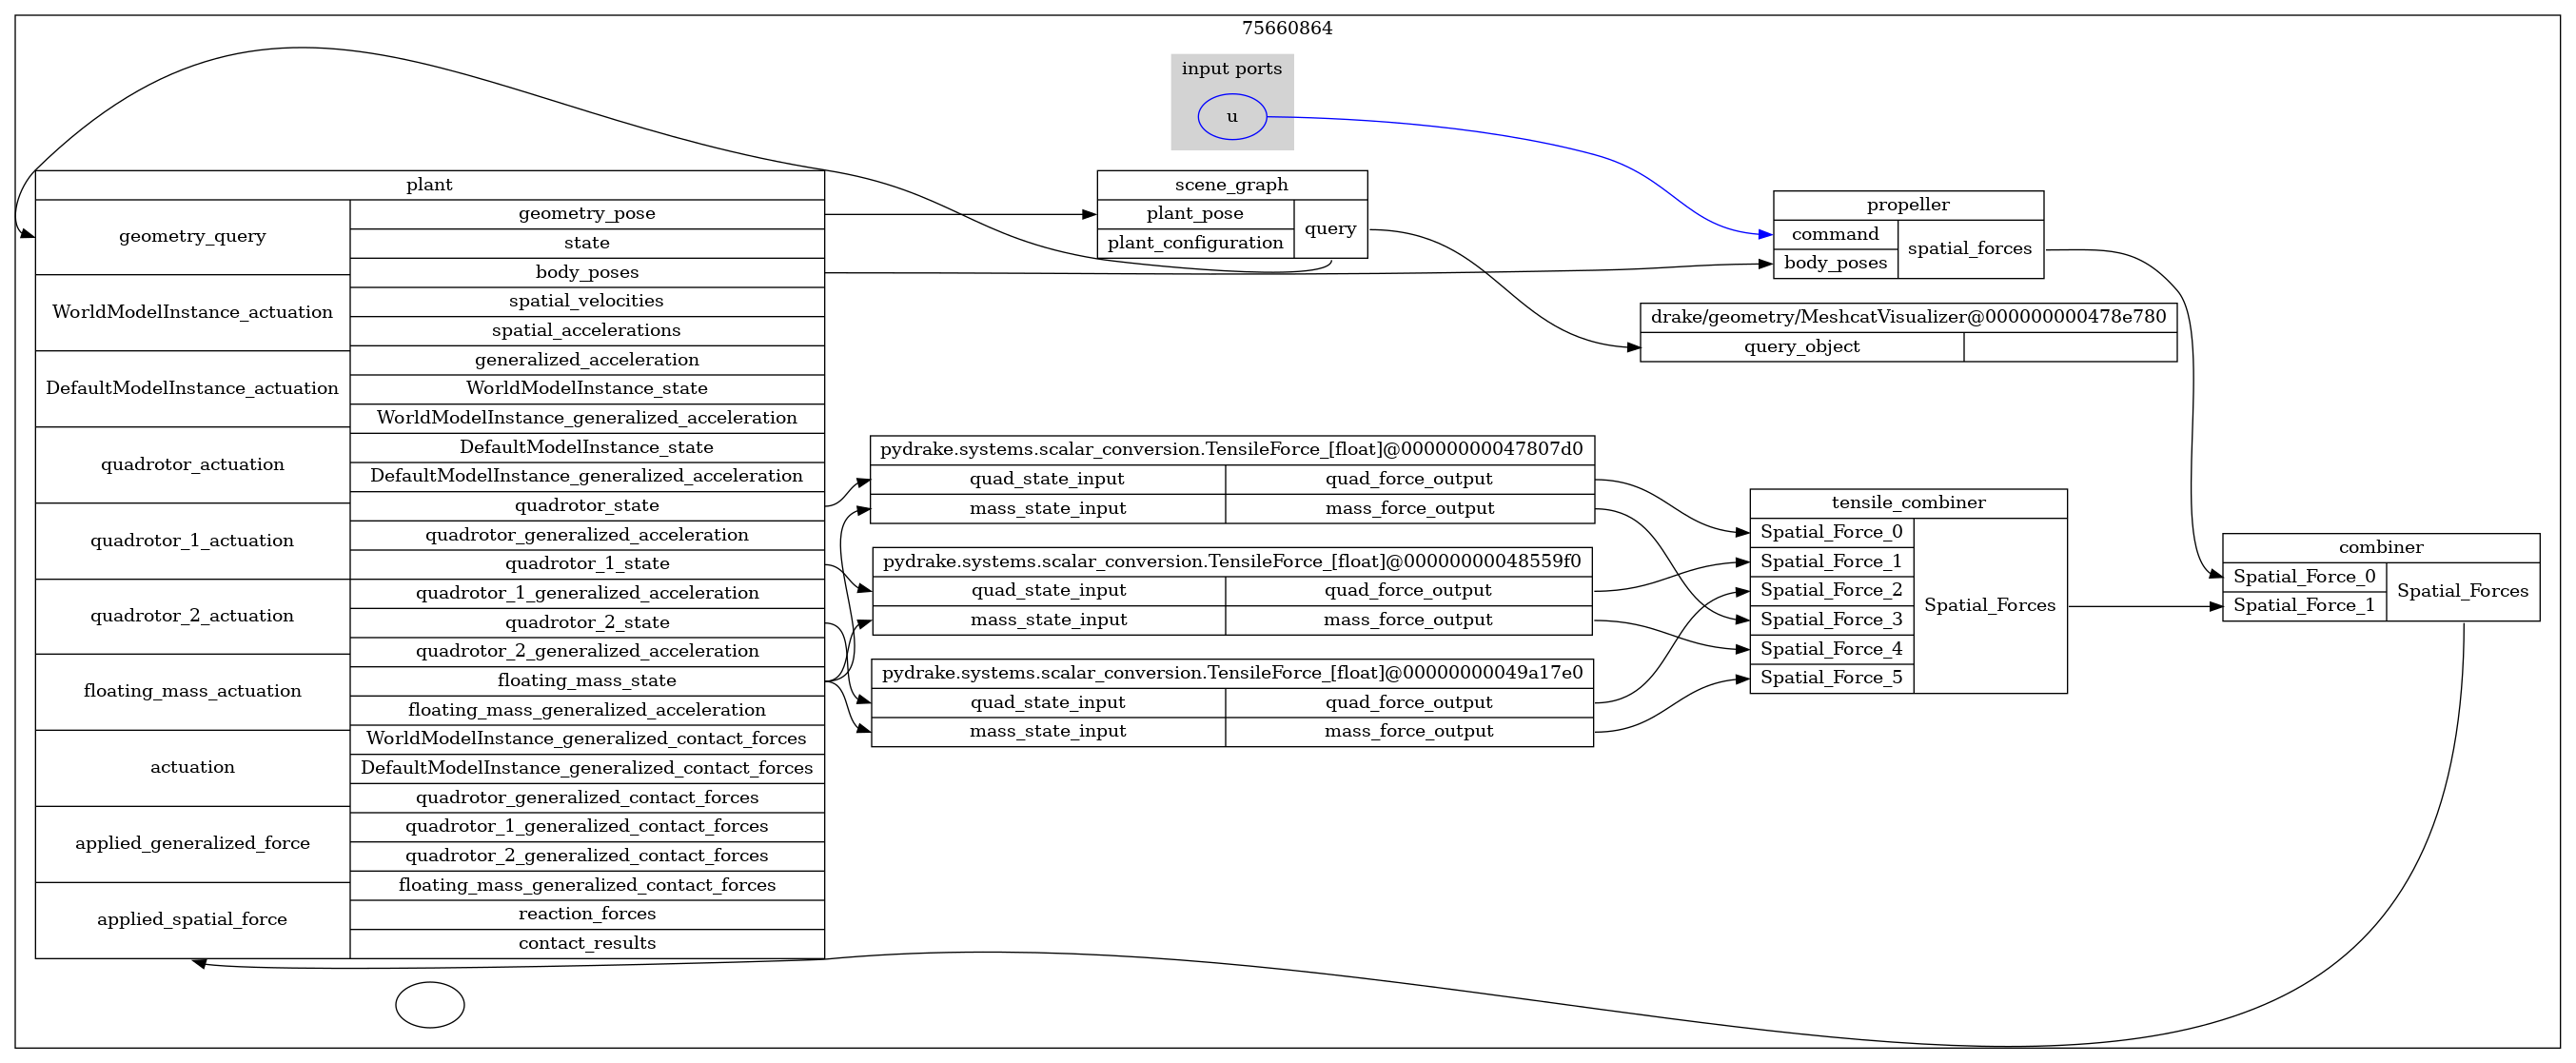

In [16]:
display(
    Image(
        pydot.graph_from_dot_data(diagram.GetGraphvizString())[
            0
        ].create_png()
    )
)

In [8]:
def CreateNullExternalForce(plant):
    f = ExternallyAppliedSpatialForce()
    f.body_index = plant.world_body().index()
    return f

In [17]:
def DisableCollisionChecking(sg):
    sg_context = sg.GetMyContextFromRoot(context)
    cfm = sg.collision_filter_manager(sg_context)

    query_object = sg.get_query_output_port().Eval(sg_context)
    inspector = query_object.inspector()

    quads = GeometrySet()
    gids = inspector.GetAllGeometryIds()
    for gid in gids:
        # Might want to handle the case where not all geometries are collision geometries?
        quads.Add(gid)
    cfd = CollisionFilterDeclaration()
    cfd.ExcludeWithin(quads)
    cfm.Apply(cfd)

In [21]:
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()

u = diagram.GetInputPort("u")
u.FixValue(context, np.zeros(u.size()))

sg = diagram.GetSubsystemByName("scene_graph")
DisableCollisionChecking(sg)

# CreateNullExternalForce(diagram.GetSubsystemByName("plant"))

# combiner_system = diagram.GetSubsystemByName("combiner")
# combiner_empty_port = combiner_system.Input_ports[1]
# combiner_empty_port.FixValue(combiner_system.GetMyContextFromRoot(context), [CreateNullExternalForce(plant)])

simulator.set_target_realtime_rate(0.1)
# Simulate
while True:
    context.SetTime(0.0)
    context.SetContinuousState(
        5
        * np.random.randn(
            context.num_continuous_states(),
        )
    )
    simulator.Initialize()
    simulator.AdvanceTo(1)



KeyboardInterrupt: 

In [ ]:
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()

u = diagram.GetInputPort("u")
u.FixValue(context, np.zeros(u.size()))

sg = diagram.GetSubsystemByName("scene_graph")
DisableCollisionChecking(sg)


context.SetTime(0.0)
# context.SetContinuousState(
#         0.25
#         * np.random.randn(
#             context.num_continuous_states(),
#         )
#     )
simulator.Initialize()
simulator.AdvanceTo(30)
